In [7]:
import pandas as pd
import numpy as np
import pyproj

import sys
sys.path.append('/Users/aless/Desktop/icedrift/src')  # Add the path to icedrift


# Define the path to the specific CSV file
file_path = "/Users/aless/Desktop/sea_ice_variability/data/buoy_data/cirfa2022/CIRFA22_206764.csv"

from icedrift.analysis import compute_velocity
from icedrift.cleaning import check_positions, check_speed, check_gaps

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, header=None, names=['datetime', 'latitude', 'longitude'])

# Convert 'datetime' column to a proper datetime object
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Check for missing or invalid values
print(df.isnull().sum())  # Check for missing data
print(df.describe())  # Check for outliers with summary statistics

# Convert latitude and longitude to numeric, drop invalid rows
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df = df.dropna(subset=['longitude', 'latitude'])

# Remove rows where latitude or longitude is outside the valid range
df_cleaned = df[(df['latitude'].between(-90, 90)) & (df['longitude'].between(-180, 180))]

# Incorporate icedrift utility functions for further data cleaning

# Check for duplicated or nonphysical positions
flag_positions = check_positions(df_cleaned, pairs_only=True)
df_cleaned = df_cleaned[~flag_positions]

# Check for gaps in data (can be done without timestamp by assuming sequential data)
flag_gaps = check_gaps(df_cleaned, threshold_gap='4h', threshold_segment=12)
df_cleaned = df_cleaned[~flag_gaps]

# Optionally, check for anomalous speeds
# flag_speed = check_speed(df_cleaned, date_index=False, window='3day', sigma=5, max_speed=1.5)
# df_cleaned = df_cleaned[~flag_speed]

# Calculate drift distance between consecutive points
df_cleaned['distance'] = np.sqrt((df_cleaned['longitude'].diff()**2) + (df_cleaned['latitude'].diff()**2))

# Define a threshold for distance to filter out extreme jumps
threshold = 0.1  # Adjust this value based on your data
df_cleaned = df_cleaned[df_cleaned['distance'] < threshold]

# Final cleaned DataFrame is now ready for further analysis or plotting
print("Cleaned DataFrame:")
print(df_cleaned.head())

datetime     1
latitude     0
longitude    0
dtype: int64
                            datetime
count                          11127
mean   2022-08-19 22:24:20.448908288
min              2022-04-25 17:00:37
25%              2022-06-22 17:45:39
50%              2022-08-20 01:00:37
75%       2022-10-17 00:15:32.500000
max              2022-12-14 02:00:39
Cleaned DataFrame:
             datetime   latitude  longitude  distance
2 2022-04-25 17:30:39  78.822905  -6.028537  0.012301
3 2022-04-25 18:00:39  78.818770  -6.039745  0.011946
4 2022-04-25 18:30:28  78.814635  -6.050889  0.011886
5 2022-04-25 19:00:37  78.810588  -6.062412  0.012213
6 2022-04-25 19:30:38  78.806767  -6.074057  0.012256


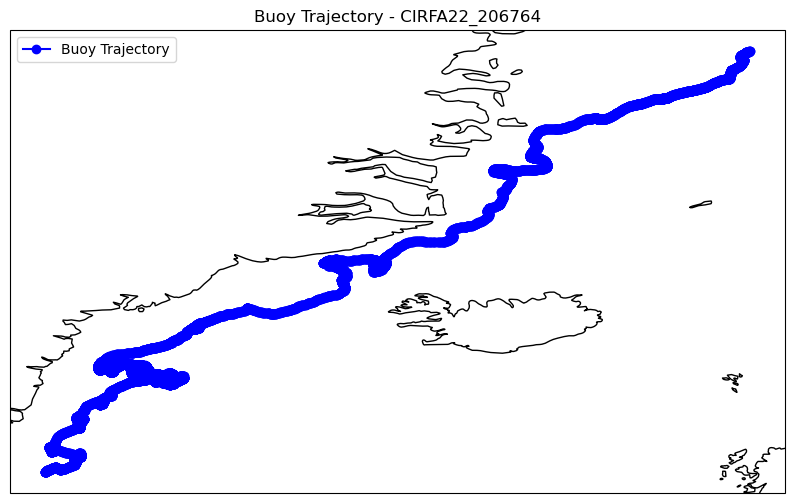

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a plot with a map background using cartopy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines for context
ax.coastlines()

# Plot the buoy trajectory using latitude and longitude
plt.plot(df_cleaned['longitude'], df_cleaned['latitude'], linestyle='-', marker='o', color='blue', label='Buoy Trajectory')

# Add labels and title
plt.title('Buoy Trajectory - CIRFA22_206764')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend
plt.legend()

# Show the plot
plt.show()

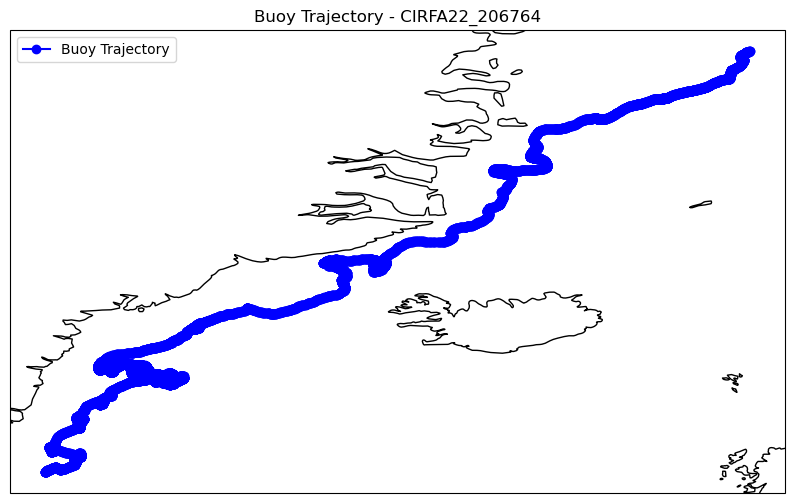

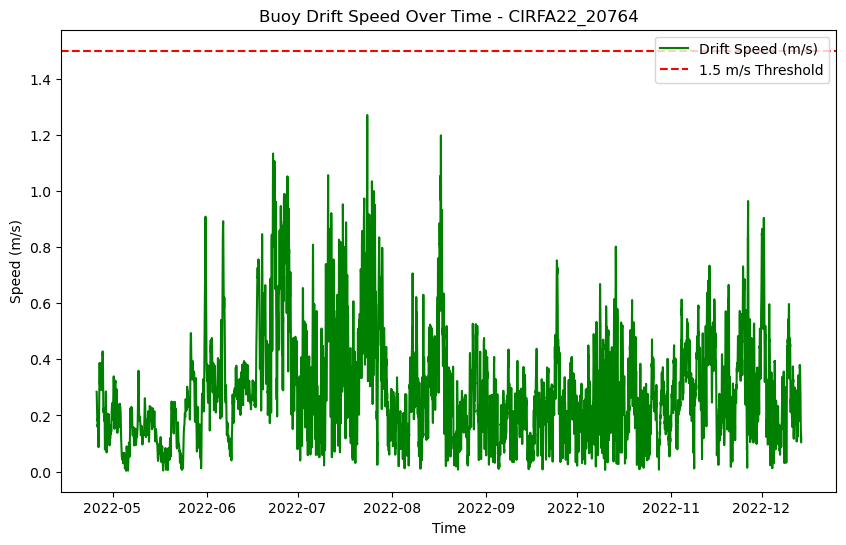

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from icedrift.analysis import compute_velocity

# Step 1: Temporarily rename 'datetime' column to 'date' for compute_velocity function compatibility
df_cleaned.rename(columns={'datetime': 'date'}, inplace=True)

# Step 2: Compute velocity using the icedrift compute_velocity function
df_velocity = compute_velocity(df_cleaned, date_index=False)

# Step 3: Plot the trajectory of the buoy on a map
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines for context
ax.coastlines()

# Plot the buoy trajectory using latitude and longitude
plt.plot(df_cleaned['longitude'], df_cleaned['latitude'], linestyle='-', marker='o', color='blue', label='Buoy Trajectory')

# Add labels and title
plt.title('Buoy Trajectory - CIRFA22_206764')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Step 4: Plot the drift speed as a time series
plt.figure(figsize=(10, 6))
plt.plot(df_velocity['date'], df_velocity['speed'], label='Drift Speed (m/s)', color='green')
plt.axhline(y=1.5, color='r', linestyle='--', label='1.5 m/s Threshold')
plt.xlabel('Time')
plt.ylabel('Speed (m/s)')
plt.title('Buoy Drift Speed Over Time - CIRFA22_20764')
plt.legend()

# Show the drift speed plot
plt.show()

# Step 5: Optionally rename 'date' back to 'datetime' after the calculation
df_cleaned.rename(columns={'date': 'datetime'}, inplace=True)